## Objective: Generate arbitrage charge/discharge schedule to couple with peak shaving
### Code adapted from Y. Baker, N. Zheng, and B. Xu, “Transferable energy storage bidder,” IEEE Transactions on Power Systems, vol. 39, no. 2, pp. 4117–4126, 2023.

## Imports

In [43]:
import sys
%reload_ext autoreload
%autoreload 2
import ESS_utils_RT
    
import scipy.io
import numpy as np
import math
import pandas as pd
from datetime import datetime
from datetime import date 
import matplotlib.pyplot as plt
from datetime import date       
import tensorflow as tf
import time
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import plot_model
from ESS_utils_RT import *
import matplotlib.pyplot as plt
import os
import cvxpy as cp
import gurobipy as gp
from gurobipy import GRB
from sklearn.neighbors import NearestNeighbors
from glob import glob
from itertools import product
import json
import matplotlib as mpl
from itertools import product
import glob

In [80]:
# Load the real-time data
RTP_NYC_all = pd.read_csv("RTP_NYC_2022_2024.csv", parse_dates=["Time Stamp"])

# Verify
print(RTP_NYC_all.head())

# Load the day-ahead data
DA_NYC_all = pd.read_csv("DA_NYC_2022_2024.csv", parse_dates=["Time Stamp"])

# Verify
print(DA_NYC_all.head())

           Time Stamp  LBMP ($/MWHr)
0 2022-01-01 00:05:00          31.83
1 2022-01-01 00:10:00          31.94
2 2022-01-01 00:15:00          31.71
3 2022-01-01 00:20:00          30.82
4 2022-01-01 00:25:00          30.59
           Time Stamp  LBMP ($/MWHr)
0 2022-01-01 00:00:00          30.95
1 2022-01-01 01:00:00          28.25
2 2022-01-01 02:00:00          26.31
3 2022-01-01 03:00:00          25.29
4 2022-01-01 04:00:00          25.24


## Prep Work

### SET PARAMS HERE

In [87]:
#Generating GT Value Functions

Ts = 1/12 # time step: 5min

# 2022-2023 train, 2024 test
train_start = pd.Timestamp("2022-01-01")
train_end   = pd.Timestamp("2023-12-31")
test_start  = pd.Timestamp("2024-01-01")
test_end    = pd.Timestamp("2024-12-31")

tlambda = RTP_NYC_all[(RTP_NYC_all["Time Stamp"] >= train_start) &
                      (RTP_NYC_all["Time Stamp"] <= train_end)]["LBMP ($/MWHr)"].values.flatten()

tlambda_DA = DA_NYC_all[(DA_NYC_all["Time Stamp"] >= train_start) &
                        (DA_NYC_all["Time Stamp"] <= train_end)]["LBMP ($/MWHr)"].values.flatten()

tlambda_test = RTP_NYC_all[(RTP_NYC_all["Time Stamp"] >= test_start) &
                           (RTP_NYC_all["Time Stamp"] <= test_end)]["LBMP ($/MWHr)"].values.flatten()

tlambda_DA_test = DA_NYC_all[(DA_NYC_all["Time Stamp"] >= test_start) &
                             (DA_NYC_all["Time Stamp"] <= test_end)]["LBMP ($/MWHr)"].values.flatten()

T = len(tlambda)        # training period length in 5-min steps
T_test = len(tlambda_test)  # test period length

rtp_NYC = RTP_NYC_all[(RTP_NYC_all["Time Stamp"] >= train_start) &
                      (RTP_NYC_all["Time Stamp"] <= train_end)]["LBMP ($/MWHr)"].values.flatten()

'''
Set parameters
'''
Pr = 1 #1/12 # normalized power rating wrt energy rating (highest power input allowed to flow through particular equipment)
P = Pr*Ts  # actual power rating taking time step size into account, 0.5*1/12 = 0.041666666666666664
eta = .9  # efficiency
c = 0  # marginal discharge cost - degradation
ed = 0.001  # SoC sample granularity
ef = 0  # final SoC target level, use 0 if none (ensure that electric vehicles are sufficiently charged at the end of the period)
Ne = math.floor(1/ed)+1  # number of SOC samples, (1/0.001)+1=1001
e0 = .5  # Beginning SoC level

'''
Downsample settings
'''
num_segment = 1

### 5 Min Valuation

In [64]:
T = len(tlambda) - int(24/Ts)

In [65]:
#GENERATING GT VALUE FUNCTION FOR TRAINING
vAvg = generate_value_function(Ts, P, eta, c, ed, ef, Ne, T, num_segment, tlambda)[1]

Time: 5.896228075027466


In [66]:
#generating test value functions to calculate benchmark profits 5 min valuation
T_test = len(tlambda_test) - int(24/Ts)
vAvg_NYC = generate_value_function(Ts, P, eta, c, ed, ef, Ne, T_test, num_segment, tlambda_test)[1]

Time: 3.335355281829834


## Training

### RTP + DAP

In [68]:
#Training + Parameter Control
num_DAP = 24
num_RTP = 36

#setting test dir info
folder = os.getcwd()

region = 'NY'
test = 'CNN_LSTM_' + str(num_segment) +'_0.5'
net = 'vanilla' # set string as t1 or vanilla based on which model you want

# Generate training set if not commented
X, y = generate_train_CNN(T=T,DAP=tlambda_DA,tlambda=tlambda, start=None,stop=None,
                          lastDay=None,num_DAP=num_DAP,num_RTP=num_RTP,vAvg=vAvg)
X = np.asarray(X)
y = np.asarray(y)

x_train, x_val, y_train, y_val = train_test_split(X, y, test_size=0.05, shuffle=True)

model = val_CNN_LSTM(output_size=num_segment, net=net)
# model.summary()

In [69]:
curr_run = net + '_best_model_epoch{epoch:02d}_loss{val_loss:.5f}.keras'
checkpoint_path = os.path.join(folder, f"{region}_tests", test, curr_run)

# uncomment for early stopping callback
# es_callback = tf.keras.callbacks.EarlyStopping(
#     monitor='val_loss',
#     min_delta=0.001,
#     patience=4,
#     verbose=0,
#     mode='auto',
#     baseline=None,
#     restore_best_weights=False
# )


epochs = 100

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 monitor='val_loss', verbose=1, 
                                                 save_best_only=True, mode='min')

start_time = time.time()

history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=epochs,batch_size=32, 
                    verbose=1, shuffle =True,
                    callbacks=[cp_callback])

end_time = time.time()
total_time_seconds = end_time - start_time
minutes = int(total_time_seconds // 60)
seconds = int(total_time_seconds % 60)

print(f"Total training time for {epochs} epochs: {minutes} minutes and {seconds} seconds.")

Epoch 1/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 627ms/step - loss: 9227.9082 - mae: 54.8062 - mse: 9227.9072    
Epoch 1: val_loss improved from inf to 4548.47559, saving model to /Users/emilylogan/Library/Mobile Documents/com~apple~CloudDocs/Desktop/LSTM-Value-Prediction-main/NY_tests/CNN_LSTM_1_0.5/vanilla_best_model_epoch01_loss4548.47559.keras
104/104 ━━━━━━━━━━━━━━━━━━━━ 74s 642ms/step - loss: 9207.8994 - mae: 54.7428 - mse: 9207.8984 - val_loss: 4548.4756 - val_mae: 35.1384 - val_mse: 4548.4756
Epoch 2/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 710ms/step - loss: 6267.3345 - mae: 36.0574 - mse: 6267.3340  
Epoch 2: val_loss improved from 4548.47559 to 3731.08276, saving model to /Users/emilylogan/Library/Mobile Documents/com~apple~CloudDocs/Desktop/LSTM-Value-Prediction-main/NY_tests/CNN_LSTM_1_0.5/vanilla_best_model_epoch02_loss3731.08276.keras
104/104 ━━━━━━━━━━━━━━━━━━━━ 74s 714ms/step - loss: 6261.8691 - mae: 36.0353 - mse: 6261.8687 - val_loss: 3731.0828 - val_mae: 28.3043 - val_mse: 373

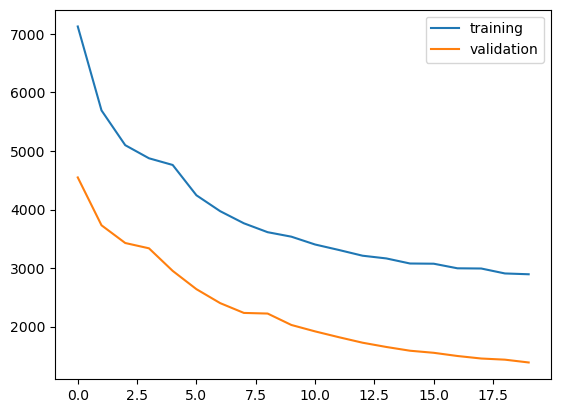

In [70]:
#training plots
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])

## Evaluation 5 min valuation 5 min Arbitrage


In [71]:
#loading weights of best previously trained model
#set up model in RTP+DAP tab under training

# Path to the checkpoints folder
checkpoint_folder = os.path.join(folder, f"{region}_tests", test)

# Get all .keras checkpoint files
all_checkpoints = sorted(glob.glob(os.path.join(checkpoint_folder, "*.keras")))

if not all_checkpoints:
    raise FileNotFoundError(f"No checkpoint files found in {checkpoint_folder}")

# Pick the latest checkpoint (last in sorted list)
latest_checkpoint = all_checkpoints[-1]

# Load weights into your model
model.load_weights(latest_checkpoint)

print(f"✅ Loaded weights")


✅ Loaded weights


In [72]:
# CNNLSTM evaluate function automatically extracts unseen test data from
# full data vector

print('NYC PREDICTED:')

# Pre-filter DA and RTP arrays for test period

v1_NYC, arb1_NY, _, arb_NYC = CNNLSTMEvaluate(
    model, 
    tlambda_DA_test,  
    tlambda_test,    
    num_DAP, 
    num_RTP, Pr=Pr, Ts = Ts, eta=eta, c=c)


NYC PREDICTED:
Evaluating on Test Set
Test data shape for prediction: (1747, 60, 60, 1)
Time to predict full year: 3.51s
Value function has shape: (1, 104820)
Arbitrage simulation time: 0.80s
Total Profit: 14,383.16
Total Revenue: 14,383.16
Total Discharge (MW): 403.12
Total Evaluation Time: 4.31s


In [86]:
# --------------------------------------------------------
# Align Arbitrage Dispatch with the Full Test-Year Timeline
# --------------------------------------------------------

# A 24-hour lookback is required before the arbitrage model 
# can start producing valid dispatch. With a 5-min timestep:
#     24 hrs / (1/12 hr per step) = 288 steps of lookback.
lookback_hours = 24
lookback_steps = int(lookback_hours / Ts) 

# Arbitrage output (power_series) is shorter because the 
# first 288 timesteps cannot produce decisions.
_, power_series = arb_NYC

# Separate charge/discharge components
charge_norm = np.abs(np.minimum(power_series, 0))   # charging
discharge_norm = np.maximum(power_series, 0)        # discharging

# Extract test-year RTP (must match dispatch length)
RTP_test = RTP_NYC_all[
    (RTP_NYC_all["Time Stamp"] >= "2024-01-01") &
    (RTP_NYC_all["Time Stamp"] <  "2025-01-01")].copy().reset_index(drop=True)

total_steps = len(RTP_test)
print(f"Test-year timesteps: {total_steps} → {total_steps / 288:.1f} days")


# Allocate full-year arrays for aligned dispatch
dispatch_full = np.zeros(total_steps)
charge_full   = np.zeros(total_steps)
discharge_full= np.zeros(total_steps)

# Shift arbitrage data forward by the lookback offset
end_idx = min(lookback_steps + len(power_series), total_steps)
dispatch_full[lookback_steps:end_idx] = power_series[:end_idx - lookback_steps]
charge_full[lookback_steps:end_idx]   = charge_norm[:end_idx - lookback_steps]
discharge_full[lookback_steps:end_idx]= discharge_norm[:end_idx - lookback_steps]


# Assemble into a DataFrame
dispatch_df = pd.DataFrame({"Time Stamp": RTP_test["Time Stamp"], "Real_Time_Price_$_per_MWh": RTP_test["LBMP ($/MWHr)"],
    "Charge_norm": charge_full, "Discharge_norm": discharge_full,})

# # --- Export to CSV ---
# dispatch_df.to_csv(f'arbitrage_data_c{c}.csv', index=False)

Test-year timesteps: 105408 → 366.0 days


## Graph Charge/Discharge Results

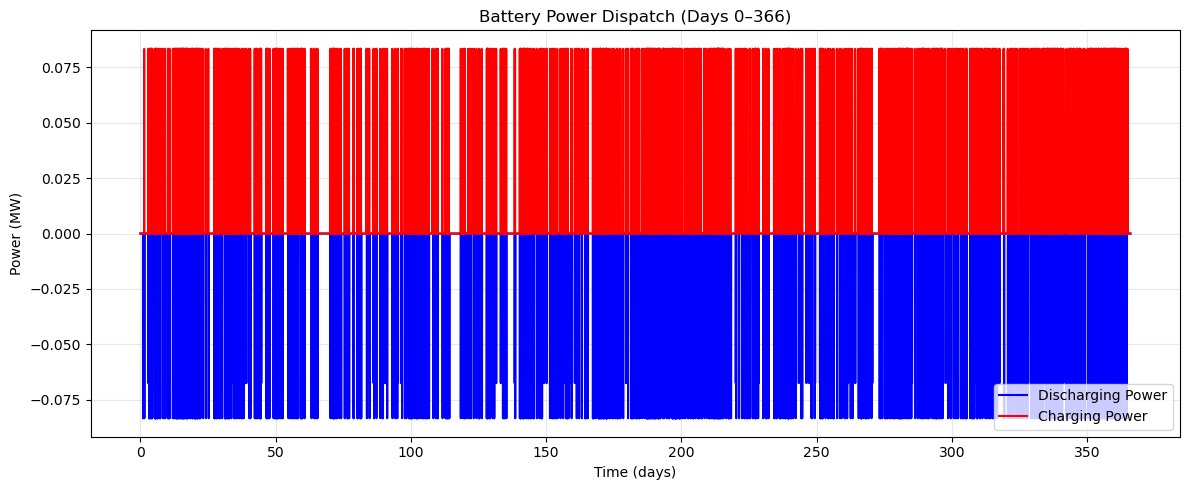

In [85]:
# --- Define window (in days) ---
start_day = 0
end_day = 366  # example: first 10 days of test year

# --- Convert timestamps to "days since start" ---
time_hours = np.arange(len(RTP_test)) * Ts     # each timestep = 1/12 hour
time_days = time_hours / 24                    # convert to days

# --- Create mask for selected time window ---
mask = (time_days >= start_day) & (time_days <= end_day)

# --- Plot only that slice ---
plt.figure(figsize=(12, 5))
plt.plot(time_days[mask], -discharge_full[mask], label='Discharging Power', color='blue')
plt.plot(time_days[mask],  charge_full[mask], label='Charging Power', color='red')

plt.xlabel('Time (days)')
plt.ylabel('Power (MW)')
plt.title(f'Battery Power Dispatch (Days {start_day}–{end_day})')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()